In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb

In [2]:
def ip_to_int(ip):
    
    try:
        return int(ipaddress.ip_address(ip))
    except Exception:
        return 0

In [3]:
def load_data(file_path):
    
    print("Loading data...")
    df = pd.read_csv(file_path)
    print(f"Data loaded. Shape: {df.shape}")
    return df

In [4]:
def remove_duplicates(df):
    
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]
    duplicates_removed = before - after
    if duplicates_removed > 0:
        print(f"Removed {duplicates_removed} duplicate rows.")
    else:
        print("No duplicate rows found.")
    return df

In [5]:
def preprocess_data(df):
    
    important_features = [
        'Flow ID', 'Timestamp', 'Fwd Seg Size Min', 
        'Src IP', 'Dst IP', 'Flow IAT Min', 
        'Src Port', 'Tot Fwd Pkts', 'Init Bwd Win Byts'
    ]
    
    # Subset the dataframe to only the important features and the target
    df = df[important_features + ['Label']]
    
    # Convert Flowid to numeric categorical codes
    df['Flow ID'] = pd.factorize(df['Flow ID'])[0]
    
    # Convert Timestamp to datetime then to epoch seconds
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df['Timestamp'] = df['Timestamp'].astype('int64') // 10**9  # Convert to seconds
    
    # Convert IP addresses to integers
    df['Src IP'] = df['Src IP'].apply(ip_to_int)
    df['Dst IP'] = df['Dst IP'].apply(ip_to_int)
    
    df['Label'] = df['Label'].map({'Benign': 0, 'ddos': 1})

    
    # Ensure remaining columns are numeric
    numeric_columns = ['Fwd Seg Size Min', 'Flow IAT Min', 'Src Port', 'Tot Fwd Pkts', 'Init Bwd Win Byts']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = remove_duplicates(df)
    
    # Optional: handle missing values (e.g., fill with 0)
    df.fillna(0, inplace=True)
    
    
    X = df.drop('Label', axis=1)
    y = df['Label']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features (especially important for Logistic Regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [6]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42,  max_depth=10, min_samples_split=5),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, max_depth=5, gamma=0.1, reg_lambda=1, reg_alpha=1),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining model: {name}")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        print(f"Training time: {train_time:.2f} seconds")
        
        # Predict on test set
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        print(f"Accuracy for {name}: {accuracy:.4f}")
        print(f"Classification Report for {name}:\n{report}")
        print(f"Confusion Matrix for {name}:\n{cm}")
        
        results[name] = {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'training_time': train_time
        }
    
    return results, models

In [7]:

# Set the file path to your 6GB CSV dataset
file_path = 'ddos_balanced/final_dataset.csv'
    
# Load the dataset
df = load_data(file_path)
df = df.sample(frac = 0.1,random_state=42)
    
# Preprocess the dataset (adjust column names as needed)
X_train, X_test, y_train, y_test = preprocess_data(df)
    
# Train and evaluate the models
results, models = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    
print("\nAll models have been trained and evaluated.")


Loading data...
Data loaded. Shape: (12794627, 85)


C:\Users\adwai\AppData\Local\Temp\ipykernel_14992\3013806273.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Flow ID'] = pd.factorize(df['Flow ID'])[0]
C:\Users\adwai\AppData\Local\Temp\ipykernel_14992\3013806273.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
C:\Users\adwai\AppData\Local\Temp\ipykernel_14992\3013806273.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Removed 2 duplicate rows.

Training model: Logistic Regression
Training time: 0.77 seconds
Accuracy for Logistic Regression: 0.8955
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89    126386
           1       0.89      0.90      0.90    129507

    accuracy                           0.90    255893
   macro avg       0.90      0.90      0.90    255893
weighted avg       0.90      0.90      0.90    255893

Confusion Matrix for Logistic Regression:
[[112341  14045]
 [ 12701 116806]]

Training model: Random Forest
Training time: 94.86 seconds
Accuracy for Random Forest: 0.9999
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126386
           1       1.00      1.00      1.00    129507

    accuracy                           1.00    255893
   macro avg       1.00      1.00      1.00    255893
weighted 

C:\Users\adwai\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training time: 3.04 seconds
Accuracy for XGBoost: 0.9999
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126386
           1       1.00      1.00      1.00    129507

    accuracy                           1.00    255893
   macro avg       1.00      1.00      1.00    255893
weighted avg       1.00      1.00      1.00    255893

Confusion Matrix for XGBoost:
[[126362     24]
 [     7 129500]]

Training model: KNN
Training time: 5.99 seconds
Accuracy for KNN: 0.9877
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    126386
           1       0.99      0.99      0.99    129507

    accuracy                           0.99    255893
   macro avg       0.99      0.99      0.99    255893
weighted avg       0.99      0.99      0.99    255893

Confusion Matrix for KNN:
[[124936   1450]
 [  1708 127799]]

All models have been t

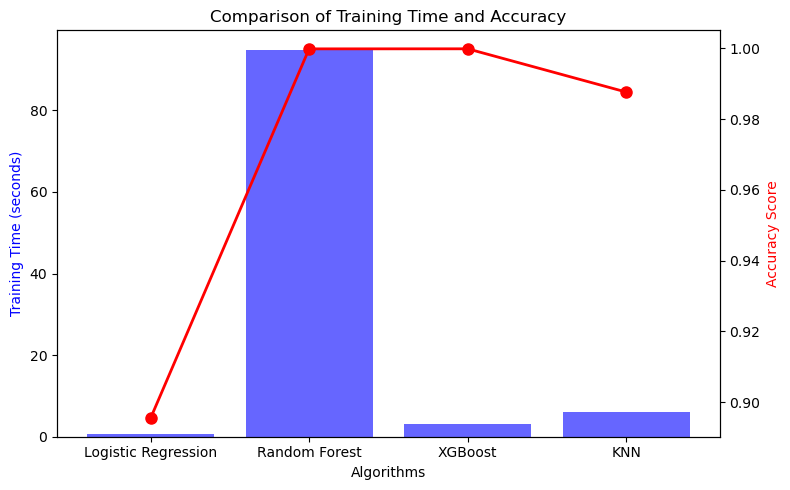

In [8]:
import matplotlib.pyplot as plt

# Extracting algorithm names, training times, and accuracies from results dictionary
algorithms = list(results.keys())
training_times = [results[algo]['training_time'] for algo in algorithms]
accuracies = [results[algo]['accuracy'] for algo in algorithms]

# Creating figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot for training time
ax1.bar(algorithms, training_times, color='blue', alpha=0.6, label="Training Time (s)")
ax1.set_ylabel("Training Time (seconds)", color='blue')
ax1.set_xlabel("Algorithms")

# Create a secondary axis for accuracy
ax2 = ax1.twinx()
ax2.plot(algorithms, accuracies, color='red', marker='o', linestyle='-', linewidth=2, markersize=8, label="Accuracy Score")
ax2.set_ylabel("Accuracy Score", color='red')

# Title and layout
plt.title("Comparison of Training Time and Accuracy")
fig.tight_layout()
plt.show()